# Estimating the `"delta departure-presentation"` 

In [282]:
import os
import logging
from tqdm import tqdm_notebook as tqdm
import numpy as np

import xgboost as xgb
from xgboost import plot_importance

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold, train_test_split , ShuffleSplit, KFold
from sklearn.impute import SimpleImputer
from sklearn.multioutput import MultiOutputRegressor

In [2]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


In [3]:
from parse import FirePandas, TIME_NORMALISER, IDX_COLNAME, train_data_path, val_data_path, test_data_path, categories_path
from challenge_utils import save_submission


## Load Datasets :

In [311]:
## for partial data :

x_features = [
    'alert reason category',
#     'alert reason',
    'intervention on public roads',
    'floor',
    'location of the event',
    'longitude intervention', 'latitude intervention',
    'emergency vehicle type',
#     'rescue center',
#     'selection time',
#     'status preceding selection',
#     'delta status preceding selection-selection',
#     'departed from its rescue center',
    'longitude before departure', 'latitude before departure',
#     'delta position gps previous departure-departure',
#     'GPS tracks departure-presentation',
#     'GPS tracks datetime departure-presentation',
    'GPS tracks datetime departure-presentation selection-first',
    'GPS tracks datetime departure-presentation selection-last',
    'GPS tracks datetime departure-presentation first-last',
    'OSRM estimated distance', 
#     'OSRM estimated duration',
    'selection time month', 
#     'selection time day', 
    'selection time hour', 
#     'selection time minute',
    'selection time day of week',
    'selection time is holiday',
    'OSRM estimated distance from last observed GPS position',
    'OSRM estimated duration from last observed GPS position',
    'time elapsed between selection and last observed GPS position',
    'updated OSRM estimated duration',
#     'weather dailyrainMM M',
    'weather dailyrainMM H',
    'weather dailyrainMM d',
#     'weather TemperatureC M',
#     'weather TemperatureC H',
#     'weather TemperatureC d',
]

y_features = [
#     'delta selection-departure',
    'delta departure-presentation',
#     'delta selection-presentation'
]


In [237]:
## for partial data :


x_features = [
    'alert reason category',
#     'alert reason',
    'intervention on public roads',
    'floor',
    'location of the event',
    'longitude intervention', 'latitude intervention',
    'emergency vehicle type',
#     'rescue center',
#     'selection time',
#     'status preceding selection',
#     'delta status preceding selection-selection',
#     'departed from its rescue center',
    'longitude before departure', 'latitude before departure',
#     'delta position gps previous departure-departure',
#     'GPS tracks departure-presentation',
#     'GPS tracks datetime departure-presentation',
    'GPS tracks datetime departure-presentation selection-first',
    'GPS tracks datetime departure-presentation selection-last',
    'GPS tracks datetime departure-presentation first-last',
    'OSRM estimated distance', 
    'OSRM estimated duration',
    'selection time month', 
#     'selection time day', 
    'selection time hour', 
#     'selection time minute',
    'selection time day of week',
    'selection time is holiday',
#     'OSRM estimated distance from last observed GPS position',
#     'OSRM estimated duration from last observed GPS position',
#     'time elapsed between selection and last observed GPS position',
#     'updated OSRM estimated duration',
#     'weather dailyrainMM M',
    'weather dailyrainMM H',
    'weather dailyrainMM d',
#     'weather TemperatureC M',
#     'weather TemperatureC H',
#     'weather TemperatureC d',
]

y_features = [
#     'delta selection-departure',
    'delta departure-presentation',
#     'delta selection-presentation'
]


In [213]:
train0_dmatrix, train1_dmatrix, test_dmatrix = None, None, None

In [214]:
X_train, y_train, X_test = None, None, None

In [312]:
train_data = FirePandas.load_pickle(train_data_path, categories_path=categories_path)
val_data   = FirePandas.load_pickle(  val_data_path, categories_path=categories_path)
test_data  = FirePandas.load_pickle( test_data_path, categories_path=categories_path)


INFO:root:Loading categories...
INFO:root:Loading categories...
INFO:root:Loading categories...


In [292]:
## keep only full training examples :
key = 'updated OSRM estimated duration'
train_data.df = train_data.df[train_data.df[key] != -1]
val_data.df   =   val_data.df[  val_data.df[key] != -1]
# train_data.df = train_data.df[train_data.df[key] != -1]


In [313]:
## keep only partial training examples :
key = 'updated OSRM estimated duration'
train_data.df = train_data.df[train_data.df[key] == -1]
# val_data.df   =   val_data.df[  val_data.df[key] == -1]
# train_data.df = train_data.df[train_data.df[key] != -1]


In [314]:
### Filter outliers :

threshold = 4
mask = train_data.df['delta departure-presentation'] < threshold
print("removing {}% ({})".format(sum(~mask)*100/len(mask), sum(~mask)))
# mask
train_data.df = train_data.df[mask]


removing 0.0158086594256807% (17)


## clustering vehicule type

In [145]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import pandas as pd

k = 10

key  = "emergency vehicle type"
key2 = 'delta departure-presentation'
col = train_data.df[[key, key2,]]

global_mean = col[key2].mean() 
col = col.groupby(key).mean().fillna(global_mean)
print(len(col))

cluster = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
new_labels = cluster.fit_predict(col)
col['emergency vehicle type clustered'] = new_labels
col = pd.get_dummies(col['emergency vehicle type clustered'].astype('category'), prefix='emergency vehicle type clustered')
new_vehicule_type_columns = col.columns
# print(col)

train_data.df = train_data.df.join(col)
val_data.df   =   val_data.df.join(col)
test_data.df  =  test_data.df.join(col)


print(new_labels)
x_features = x_features + list(new_vehicule_type_columns)

75
[9 9 3 9 2 6 3 4 2 7 8 2 4 3 3 7 3 3 9 7 3 7 3 9 3 7 0 3 2 3 5 3 1 3 3 9 4
 2 9 3 3 3 3 2 9 7 7 3 3 2 2 6 5 8 0 8 2 9 3 9 7 3 8 5 2 0 1 6 3 3 5 2 5 4
 0]


In [222]:
# train_data.df.info(verbose=True)

In [315]:
train_dmatrix = train_data.get_DMatrix(x_features, y_features=y_features)
val_dmatrix   =   val_data.get_DMatrix(x_features, y_features=y_features)
test_dmatrix  =  test_data.get_DMatrix(x_features)
print('train: {}, val: {}, test: {}'.format(train_dmatrix.num_row(), val_dmatrix.num_row(), test_dmatrix.num_row()))
print('num_features = {}\n'.format(train_dmatrix.num_col()))
_ = [print(x) for x in zip(train_dmatrix.feature_names, train_dmatrix.feature_types)]

INFO:root:Creating DMatrix...
INFO:root:Creating DMatrix...
INFO:root:Creating DMatrix...


train: 107519, val: 65802, test: 108033
num_features = 107

('alert reason category 1.0', 'int')
('alert reason category 2.0', 'int')
('alert reason category 3.0', 'int')
('alert reason category 4.0', 'int')
('alert reason category 5.0', 'int')
('alert reason category 6.0', 'int')
('alert reason category 7.0', 'int')
('alert reason category 8.0', 'int')
('alert reason category 9.0', 'int')
('alert reason category nan', 'int')
('intervention on public roads', 'float')
('floor', 'float')
('location of the event', 'float')
('longitude intervention', 'float')
('latitude intervention', 'float')
('emergency vehicle type AR', 'int')
('emergency vehicle type BEAA BSPP', 'int')
('emergency vehicle type CA', 'int')
('emergency vehicle type CCR BSPP', 'int')
('emergency vehicle type CD BSPP', 'int')
('emergency vehicle type CESD', 'int')
('emergency vehicle type CFS', 'int')
('emergency vehicle type CMO APP', 'int')
('emergency vehicle type CRAC', 'int')
('emergency vehicle type CRF', 'int')
('em

In [316]:
idx_test, _ = test_data.get_numpy([])

INFO:root:Creating numpy arrays...


---

##  parameter tuning 

from https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f 

In [44]:
params = {
    # Parameters that we are going to tune.
    'max_depth': 5,
    'min_child_weight': 3,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': .4,
    # Other parameters
    'objective':'reg:squarederror',
}

In [28]:
# params['eval_metric'] = "rmse" #"rmse" "mse"  ??? TODO

In [29]:
num_boost_round = 999

## Parameters `max_depth` and `min_child_weight`
`

In [30]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in [3, 5, 10, 20, 30]
    for min_child_weight in [1, 3, 5, 8]
]
print(len(gridsearch_params))

20


In [31]:
%time 

# Define initial best params and RMSE
min_rmse = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    %time cv_results = xgb.cv(\
            params, train_dmatrix,\
            num_boost_round=num_boost_round,\
            seed=42, nfold=5, \
            metrics={'rmse'},\
            early_stopping_rounds=5\
    )
    # Update best RMSE
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

CPU times: user 12 µs, sys: 3 µs, total: 15 µs
Wall time: 27.4 µs
CV with max_depth=3, min_child_weight=1
CPU times: user 2min 51s, sys: 4.49 s, total: 2min 55s
Wall time: 26.5 s
	RMSE 0.187571 for 19 rounds
CV with max_depth=3, min_child_weight=3


/home/pierre/.conda/envs/py3k/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


CPU times: user 3min 49s, sys: 4.92 s, total: 3min 54s
Wall time: 34.1 s
	RMSE 0.1811144 for 29 rounds
CV with max_depth=3, min_child_weight=5
CPU times: user 4min 24s, sys: 5.1 s, total: 4min 29s
Wall time: 38.6 s
	RMSE 0.1812384 for 35 rounds
CV with max_depth=3, min_child_weight=8
CPU times: user 4min 42s, sys: 5.1 s, total: 4min 47s
Wall time: 41.1 s
	RMSE 0.1804606 for 37 rounds
CV with max_depth=5, min_child_weight=1
CPU times: user 2min 37s, sys: 3.52 s, total: 2min 41s
Wall time: 23.2 s
	RMSE 0.18581219999999998 for 8 rounds
CV with max_depth=5, min_child_weight=3
CPU times: user 4min 59s, sys: 3.86 s, total: 5min 3s
Wall time: 41.3 s
	RMSE 0.1802326 for 24 rounds
CV with max_depth=5, min_child_weight=5
CPU times: user 3min 48s, sys: 3.76 s, total: 3min 52s
Wall time: 32.2 s
	RMSE 0.18065959999999998 for 16 rounds
CV with max_depth=5, min_child_weight=8
CPU times: user 4min 7s, sys: 3.63 s, total: 4min 10s
Wall time: 34.6 s
	RMSE 0.18030859999999999 for 18 rounds
CV with max_de

In [32]:
params['max_depth'] = 5
params['min_child_weight'] = 3


## Parameters `subsample` and `colsample_bytree`

In [42]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [1]
    for colsample in [.4]
]

In [43]:
%time

min_rmse = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    %time cv_results = xgb.cv(\
        params, train_dmatrix,\
        num_boost_round=num_boost_round,\
        seed=42, nfold=5,\
        metrics={'rmse'},\
        early_stopping_rounds=5\
    )
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds\n".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (subsample,colsample)
print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

CPU times: user 0 ns, sys: 10 µs, total: 10 µs
Wall time: 21.2 µs
CV with subsample=1, colsample=0.4
CPU times: user 5min 19s, sys: 5.71 s, total: 5min 24s
Wall time: 46.2 s
	RMSE 0.1737558 for 54 rounds

Best params: 1, 0.4, RMSE: 0.1737558


/home/pierre/.conda/envs/py3k/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


#### Saved outputs :

```bash
CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 21.7 µs
CV with subsample=1, colsample=0.7
CPU times: user 4min 45s, sys: 6.46 s, total: 4min 52s
Wall time: 44.2 s
	RMSE 0.17501899999999998 for 28 rounds

CV with subsample=1, colsample=0.6
CPU times: user 5min 14s, sys: 6.49 s, total: 5min 20s
Wall time: 46.8 s
	RMSE 0.17441979999999999 for 36 rounds

CV with subsample=1, colsample=0.4
CPU times: user 5min 28s, sys: 6.26 s, total: 5min 35s
Wall time: 48.4 s
	RMSE 0.1737558 for 54 rounds

CV with subsample=1, colsample=0.2
CPU times: user 2min 57s, sys: 5.63 s, total: 3min 3s
Wall time: 28.1 s
	RMSE 0.1739952 for 34 rounds

Best params: 1, 0.4, RMSE: 0.1737558
```
---

``` bash
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs
CV with subsample=1, colsample=1
CPU times: user 5min 25s, sys: 5.02 s, total: 5min 30s
Wall time: 50.1 s
	RMSE 0.1802326 for 24 rounds

CV with subsample=1, colsample=0.9
CPU times: user 4min 58s, sys: 5.47 s, total: 5min 4s
Wall time: 46.5 s
	RMSE 0.1802654 for 23 rounds

CV with subsample=1, colsample=0.8
CPU times: user 3min 36s, sys: 4.97 s, total: 3min 41s
Wall time: 33.9 s
	RMSE 0.18006780000000003 for 16 rounds

CV with subsample=1, colsample=0.7
CPU times: user 3min 14s, sys: 4.58 s, total: 3min 18s
Wall time: 29.6 s
	RMSE 0.1796668 for 16 rounds

CV with subsample=0.9, colsample=1
CPU times: user 5min 17s, sys: 4.88 s, total: 5min 22s
Wall time: 45.7 s
	RMSE 0.180654 for 21 rounds

CV with subsample=0.9, colsample=0.9
CPU times: user 3min 55s, sys: 4.47 s, total: 3min 59s
Wall time: 34.8 s
	RMSE 0.18025379999999996 for 15 rounds

CV with subsample=0.9, colsample=0.8
CPU times: user 3min 40s, sys: 4.63 s, total: 3min 45s
Wall time: 33 s
	RMSE 0.1811836 for 15 rounds

CV with subsample=0.9, colsample=0.7
CPU times: user 3min 20s, sys: 4.87 s, total: 3min 25s
Wall time: 31.1 s
	RMSE 0.1807004 for 14 rounds

CV with subsample=0.8, colsample=1
CPU times: user 4min 34s, sys: 4.63 s, total: 4min 39s
Wall time: 40.6 s
	RMSE 0.1804856 for 15 rounds

CV with subsample=0.8, colsample=0.9
CPU times: user 4min 25s, sys: 5.8 s, total: 4min 31s
Wall time: 42.3 s
	RMSE 0.1807324 for 15 rounds

CV with subsample=0.8, colsample=0.8
CPU times: user 4min 3s, sys: 5.46 s, total: 4min 8s
Wall time: 38.9 s
	RMSE 0.1813846 for 15 rounds

CV with subsample=0.8, colsample=0.7
CPU times: user 3min 48s, sys: 5.63 s, total: 3min 53s
Wall time: 37.2 s
	RMSE 0.18047580000000002 for 15 rounds

CV with subsample=0.7, colsample=1
CPU times: user 4min 53s, sys: 6.32 s, total: 5min
Wall time: 48.3 s
	RMSE 0.18165840000000003 for 13 rounds

CV with subsample=0.7, colsample=0.9
CPU times: user 5min 39s, sys: 6.08 s, total: 5min 45s
Wall time: 51.9 s
	RMSE 0.1814856 for 21 rounds

CV with subsample=0.7, colsample=0.8
CPU times: user 5min 41s, sys: 6.18 s, total: 5min 48s
Wall time: 52.6 s
	RMSE 0.1810856 for 23 rounds

CV with subsample=0.7, colsample=0.7
CPU times: user 4min 2s, sys: 5.61 s, total: 4min 8s
Wall time: 38.3 s
	RMSE 0.1809832 for 16 rounds

Best params: 1, 0.7, RMSE: 0.1796668
```

In [35]:
params['subsample'] = 1
params['colsample_bytree'] = 0.4

## Parameter `ETA`

In [36]:
%time
# This can take some time…
min_rmse = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    %time cv_results = xgb.cv(\
            params, train_dmatrix,\
            num_boost_round=num_boost_round,\
            seed=42, nfold=5, \
            metrics=['rmse'],\
            early_stopping_rounds=10\
          )
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds\n".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = eta
print("Best params: {}, RMSE: {}".format(best_params, min_rmse))


CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 14.1 µs
CV with eta=0.3
CPU times: user 3min 58s, sys: 5.38 s, total: 4min 3s
Wall time: 37.2 s
	RMSE 0.1796668 for 16 rounds

CV with eta=0.2


/home/pierre/.conda/envs/py3k/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  del sys.path[0]


CPU times: user 6min 42s, sys: 6.84 s, total: 6min 49s
Wall time: 1min 1s
	RMSE 0.1798012 for 36 rounds

CV with eta=0.1
CPU times: user 14min 27s, sys: 8.81 s, total: 14min 36s
Wall time: 2min 2s
	RMSE 0.1789054 for 99 rounds

CV with eta=0.05
CPU times: user 24min 41s, sys: 7.59 s, total: 24min 49s
Wall time: 3min 13s
	RMSE 0.1785664 for 190 rounds

CV with eta=0.01
CPU times: user 1h 29min 46s, sys: 21.2 s, total: 1h 30min 7s
Wall time: 11min 39s
	RMSE 0.1786932 for 720 rounds

CV with eta=0.005
CPU times: user 2h 13min 47s, sys: 55.8 s, total: 2h 14min 43s
Wall time: 18min 24s
	RMSE 0.17913679999999998 for 998 rounds

Best params: 0.05, RMSE: 0.1785664


In [40]:
params['eta'] = 0.05

## Final params and model estimation :

In [288]:
params = {
    # Parameters that we are going to tune.
    'max_depth':10,
    'min_child_weight': 3,
    'eta': .2,
    'subsample': .5,
    'colsample_bytree': .4,
    # Other parameters
    'objective':'reg:squarederror',
#     'num_boost_round': 100
}
num_boost_round = 999

In [261]:
model = xgb.train(
    params,
    train_dmatrix,
    num_boost_round=num_boost_round,
    evals=[(val_dmatrix, "Val")],
    early_stopping_rounds=10
)

print("Best RMSE: {:.2f} in {} rounds".format(model.best_score, model.best_iteration+1))


[0]	Val-rmse:0.217934
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.187698
[2]	Val-rmse:0.163333
[3]	Val-rmse:0.144452
[4]	Val-rmse:0.131016
[5]	Val-rmse:0.121241
[6]	Val-rmse:0.113973
[7]	Val-rmse:0.112711
[8]	Val-rmse:0.108208
[9]	Val-rmse:0.104925
[10]	Val-rmse:0.103775
[11]	Val-rmse:0.101871
[12]	Val-rmse:0.100637
[13]	Val-rmse:0.099198
[14]	Val-rmse:0.098341
[15]	Val-rmse:0.097541
[16]	Val-rmse:0.096978
[17]	Val-rmse:0.096395
[18]	Val-rmse:0.096338
[19]	Val-rmse:0.096128
[20]	Val-rmse:0.09608
[21]	Val-rmse:0.096079
[22]	Val-rmse:0.095999
[23]	Val-rmse:0.095952
[24]	Val-rmse:0.095972
[25]	Val-rmse:0.095859
[26]	Val-rmse:0.095876
[27]	Val-rmse:0.095999
[28]	Val-rmse:0.095825
[29]	Val-rmse:0.095714
[30]	Val-rmse:0.095581
[31]	Val-rmse:0.095622
[32]	Val-rmse:0.095397
[33]	Val-rmse:0.095621
[34]	Val-rmse:0.095467
[35]	Val-rmse:0.09547
[36]	Val-rmse:0.095179
[37]	Val-rmse:0.095148
[38]	Val-rmse:0.095285
[39]	Val-rmse:0.095289
[40]	Val-rmse:0.095222
[41]	Val-rmse

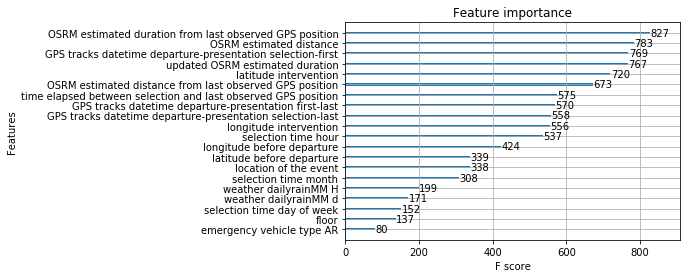

In [262]:
plot_importance(model, max_num_features=20)
plt.show()

### KFolds :

In [317]:
full_df = train_data.df.append(val_data.df)


In [319]:
## crossval
rs = KFold(n_splits=5, random_state=12, shuffle=True)
predictions  = []
for train_index, val_index in tqdm(rs.split(full_df)):
#     mask_train = np.zeros(len(full_df), dtype=int)
#     mask_train[train_index] = 1
    train_data.df = full_df.iloc[train_index]
    train_dmatrix = train_data.get_DMatrix(x_features, y_features=y_features)
    
#     mask_val = np.zeros(len(full_df), dtype=int)
#     mask_val[val_index] = 1
    val_data.df = full_df.iloc[val_index]    
    val_dmatrix   =   val_data.get_DMatrix(x_features, y_features=y_features)

    model = xgb.train(
        params,
        train_dmatrix,
        num_boost_round=num_boost_round,
        evals=[(val_dmatrix, "Val")],
        early_stopping_rounds=10,
        verbose_eval=False,
    )

    print("Best RMSE: {:.4f} in {} rounds".format(model.best_score, model.best_iteration+1))
    val_pred = model.predict(val_dmatrix)
    _, _, val_truth = val_data.get_numpy([], y_features=y_features)
    print("r2_score : ",r2_score(val_truth, val_pred))
    
    predictions.append(model.predict(test_dmatrix))
    

    

INFO:root:Creating DMatrix...
INFO:root:Creating DMatrix...
INFO:root:Creating numpy arrays...


Best RMSE: 0.1933 in 34 rounds
r2_score :  0.27278780196579033


INFO:root:Creating DMatrix...
INFO:root:Creating DMatrix...
INFO:root:Creating numpy arrays...


Best RMSE: 0.1499 in 33 rounds
r2_score :  0.3922783402255485


INFO:root:Creating DMatrix...
INFO:root:Creating DMatrix...
INFO:root:Creating numpy arrays...


Best RMSE: 0.1663 in 27 rounds
r2_score :  0.3595592818153417


INFO:root:Creating DMatrix...
INFO:root:Creating DMatrix...
INFO:root:Creating numpy arrays...


Best RMSE: 0.1734 in 27 rounds
r2_score :  0.32521048932617636


INFO:root:Creating DMatrix...
INFO:root:Creating DMatrix...
INFO:root:Creating numpy arrays...


Best RMSE: 0.1591 in 27 rounds
r2_score :  0.3475125843700788



In [322]:
test_pred = np.median(np.stack(predictions, axis=1), axis=1)
# test_pred = np.mean(np.stack(predictions, axis=1), axis=1)


In [318]:
full_predictions = predictions

 - prediction_xgboost_1_full_mean_2019-12-31_00-25.pkl
 - prediction_xgboost_1_full_median_2019-12-31_00-25.pkl
 - prediction_xgboost_1_partial_mean_2019-12-31_00-28.pkl
 - prediction_xgboost_1_partial_median_2019-12-31_00-29.pkl

In [263]:
## r2 score :
val_pred = model.predict(val_dmatrix)
_, _, val_truth = val_data.get_numpy(x_features, y_features=y_features)

r2_score(val_truth, val_pred)

INFO:root:Creating numpy arrays...


0.8200166586310946

#### last r2score :
 - prediction_xgboost_1_2019-12-25_15-55.pkl `0.431252`
 - avec méteo `0.388823` prediction_xgboost_1_2019-12-25_22-17.pkl
 - sans infos a la minute et time jour + minute : prediction_xgboost_1_2019-12-25_22-32.pkl `0.38807`

In [264]:
## full 0.82 : prediction_xgboost_1_2019-12-30_22-47.pkl
val_pred_fulldata = val_pred
val_truth_fulldata = val_truth
model_fulldata = model

In [249]:
## 0.268 partial : prediction_xgboost_1_2019-12-30_22-45.pkl
val_pred_partial = val_pred
val_truth_partial = val_truth
model_partial = model

In [265]:
r2_score(np.concatenate((val_truth_fulldata, val_truth_partial)), 
np.concatenate((val_pred_fulldata, val_pred_partial)))

0.391560033686012

## Generate prediction :

In [303]:
import pickle as pkl
import pandas as pd
import time


In [323]:
# test_pred = model.predict(test_dmatrix)
prediction_path = 'prediction_xgboost_1_partial_median_{}.pkl'.format(time.strftime("%Y-%m-%d_%H-%M"))
with open(prediction_path, 'wb') as f:
    pkl.dump(test_pred, f)
print('prediction saved at {}'.format(prediction_path))

prediction saved at prediction_xgboost_1_partial_median_2019-12-31_00-29.pkl


## Generate submission :

In [326]:
# load splited data :
full_path = "prediction_xgboost_1_full_median_2019-12-31_00-25.pkl"
partial_path = "prediction_xgboost_1_partial_median_2019-12-31_00-29.pkl"

with open(full_path, 'rb') as f :
    full = pkl.load(f) * TIME_NORMALISER[1]
with open(partial_path, 'rb') as f :
    partial = pkl.load(f) * TIME_NORMALISER[1]

fuse_df = test_data.df[["emergency vehicle selection", 'updated OSRM estimated duration']]
fuse_df['full'] = full
fuse_df['partial'] = partial
mask  =fuse_df['updated OSRM estimated duration']==-1
fuse_df['out'] = np.nan
print(fuse_df.out.isna().sum())
fuse_df.out[mask] = fuse_df.partial[mask]
print(fuse_df.out.isna().sum())
fuse_df.out[~mask] = fuse_df.full[~mask]
print(fuse_df.out.isna().sum())



108033
32435
0


/home/pierre/.conda/envs/py3k/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/pierre/.conda/envs/py3k/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/pierre/.conda/envs/py3k/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [327]:
first_col_name  = "prediction_xgboost_0_median_2019-12-31_00-00.pkl"
# second_col_name = "prediction_xgboost_1_2019-12-25_22-32.pkl"

with open(first_col_name, 'rb') as f :
    first_col = pkl.load(f) * TIME_NORMALISER[1]

# with open(second_col_name, 'rb') as f :
#     second_col = pkl.load(f) * TIME_NORMALISER[1]
second_col = fuse_df.out.data

df_idx = pd.read_csv('submission_100.csv')
idx = df_idx["emergency vehicle selection"].data

save_submission('xgboost_new3_median.csv', np.stack((idx, first_col, second_col, first_col+second_col), axis=1))

/home/pierre/.conda/envs/py3k/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Series.data is deprecated and will be removed in a future version
  if __name__ == '__main__':
/home/pierre/.conda/envs/py3k/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Series.data is deprecated and will be removed in a future version
  if sys.path[0] == '':


submission saved at 'xgboost_new3_median.csv'


In [61]:
k = 'time elapsed between selection and last observed GPS position'
col = train_data.df[k]
col


156359   -1.000000
169857   -1.000000
155050   -1.000000
211405   -1.000000
208835    0.237080
            ...   
151148   -1.000000
119025   -1.000000
207841    0.886737
46624     0.569433
111082   -1.000000
Name: time elapsed between selection and last observed GPS position, Length: 153535, dtype: float32